## Testing the halo_run catalog
#### Zhuowen Zhang; Created Oct. 10, 2018

Testing properties of the halo_run catalog and comparing it with the Chinchilla_unique catalog. 

### Initial setup

In [106]:
import numpy as np
import sys
sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty
plot_pretty()

# setup notebook for inline figures
%matplotlib inline

### Importing Halo Files

#### Halo_Run Catalog
Some notes about the catalog:
1. M200 refers to the Virial mass in the old catalog, the full_halo catalog has M200B param
2. 5e13 halos exclude subhalos which are filtered out by the halo exclusion algorithm in the ROCKSTAR finder, even if mass of subhalos are larger. That means halos are unlikely to be within ~R_vir of each other. 
3. Cuts of halo run are : lambda > 5, Mvir > 5e13, mask_frac >0.2. The mask_frac is not in the truth catalog, and may explain the mismatch in ID between halo_run and Chinchilla matched halos_redM
4. Bug: R200 same as M200

For consistency will convert the FITS data into a record array. That's more familiar to work with.

In [107]:
from tools.setup.setup import data_home_dir, home_dir
import astropy.io.fits as fits
datadir = data_home_dir()
homedir = home_dir()
hrun_dir = datadir + 'halo_run/'+'buzzard-0_1.6_y3_run_halos_lambda_chisq_chto_fullhalo_final_chto.fit'
hrun_list = fits.open(hrun_dir)
hrun_data = hrun_list[1].data

#Checking FITS into
#hrun_list.info()
print "Names of columns in hrun_data are: \n"
print hrun_data.names

#Converting FITS files into record array
hrun_data = np.array(hrun_data, dtype=hrun_data.dtype)
hrun_data = hrun_data.view(np.recarray)

print "\n Number of halos is", len(hrun_data)

Names of columns in hrun_data are: 

['HALOID', 'Mvir', 'R200', 'MEM_MATCH_ID', 'RA', 'DEC', 'Z', 'P_BCG', 'Z_LAMBDA', 'LAMBDA_CHISQ', 'LAMBDA_CHISQ_E', 'LAMBDA_CHISQ_ZORIG', 'SCALEVAL', 'LAMBDA_ZRED', 'LAMBDA_ZRED_E', 'MASKFRAC', 'GEOMASKFRAC', 'R_LAMBDA', 'R_MASK', 'Z_LAMBDA_E', 'NCROSS', 'Z_LAMBDA_NITER', 'DLAMBDA_DZ', 'DLAMBDA_DZ2', 'DLAMBDAVAR_DZ', 'DLAMBDAVAR_DZ2', 'C_LAMBDA', 'C_LAMBDA_ERR', 'MAG_LAMBDA_ERR', 'PZBINS', 'PZ', 'Z_LAMBDA_RAW', 'Z_LAMBDA_E_RAW', 'BCG_SPEC_Z', 'LIM_EXPTIME', 'LIM_LIMMAG_DERED', 'LIM_LIMMAG', 'LIM_LIMMAG_HARD', 'ra_cent', 'dec_cent', 'p_cen', 'p_sat', 'ID_CENT', 'M200B']

 Number of halos is 144508


#### redMaPPer matched halos from Chinchilla

In [108]:
#Miscentering cut
import pickle

#Loading the centered/miscentered halo IDs
matched_redM = homedir + 'output/buzzard/redM_matched_v1.2.data'
matched_halos = homedir + 'output/buzzard/halos_matched_v1.2.data'

infile = open(matched_redM,'rb')
matched_redM = pickle.load(infile)

infile = open(matched_halos,'rb')
redM_halos = pickle.load(infile)


cent_ind = np.where(matched_redM['centered_flag'] == 1)
miscent_ind = np.where(matched_redM['centered_flag'] == 0)

redM_cent = matched_redM[cent_ind]
halos_cent = redM_halos[cent_ind]
redM_miscent = matched_redM[miscent_ind]
halos_miscent = redM_halos[miscent_ind]

redM_cent = redM_cent.view(np.recarray)
redM_miscent = redM_miscent.view(np.recarray)
halos_cent = halos_cent.view(np.recarray)
halos_miscent = halos_miscent.view(np.recarray)
redM_halos = redM_halos.view(np.recarray)
matched_redM = matched_redM.view(np.recarray)

print len(matched_redM), matched_redM.dtype
print redM_halos.dtype

print len(redM_cent), len(halos_cent)
print len(redM_miscent), len(halos_miscent)

18463 (numpy.record, [('MEM_MATCH_ID', '>i4'), ('RA', '>f8'), ('DEC', '>f8'), ('MODEL_MAG', '>f4', (4,)), ('MODEL_MAGERR', '>f4', (4,)), ('REFMAG', '>f4'), ('REFMAG_ERR', '>f4'), ('ZRED', '>f4'), ('ZRED_E', '>f4'), ('ZRED_CHISQ', '>f4'), ('BCG_SPEC_Z', '>f4'), ('Z_SPEC_INIT', '>f4'), ('Z_INIT', '>f4'), ('Z', '>f4'), ('LAMBDA_CHISQ', '>f4'), ('LAMBDA_CHISQ_E', '>f4'), ('LAMBDA_ZRED', '>f4'), ('LAMBDA_ZRED_E', '>f4'), ('R_LAMBDA', '>f4'), ('SCALEVAL', '>f4'), ('MASKFRAC', '>f4'), ('GEOMASKFRAC', '>f4'), ('C_LAMBDA', '>f4', (3,)), ('C_LAMBDA_ERR', '>f4', (3,)), ('MAG_LAMBDA_ERR', '>f4', (4,)), ('CHISQ', '>f4'), ('Z_LAMBDA', '>f4'), ('Z_LAMBDA_E', '>f4'), ('Z_LAMBDA_NITER', '>i2'), ('EBV_MEAN', '>f4'), ('LNLAMLIKE', '>f4'), ('LNBCGLIKE', '>f4'), ('LNLIKE', '>f4'), ('PZBINS', '>f4', (21,)), ('PZ', '>f4', (21,)), ('NCROSS', '>i2'), ('RMASK', '>f4'), ('RA_ORIG', '>f8'), ('DEC_ORIG', '>f8'), ('W', '>f4'), ('DLAMBDA_DZ', '>f4'), ('DLAMBDA_DZ2', '>f4'), ('DLAMBDAVAR_DZ', '>f4'), ('DLAMBDAVAR_DZ2

#### Buzzard v1.6 halos, no redMaPPer matched

### Comparing halo_run vs. halo_redM_matched

#### Apply cuts
e.g. for matched_halos found in halo_run; or for clusters with MEM_MATCH_ID found in halo_run

In [109]:
#Apply mass cut
mass_lower = 5e13 #Msun/h

#Halo-run mass cut
mcut = np.where(hrun_data.M200B >= mass_lower)[0] #Again, M200 in hrun is actually Mvir
hrun_data = hrun_data[mcut]

#matched_halo mass cut
mcut = np.where(redM_halos.M200B >= mass_lower)[0]
redM_halos = redM_halos[mcut]
                            
print "After mass cut:"
print "Number of halos in halo_run is ", len(hrun_data_mcut)
print "Number of halos in matched_halos is ", len(redM_halos_mcut)

After mass cut:
Number of halos in halo_run is  144508
Number of halos in matched_halos is  16432


#### Sanity check: Searching for identical halos. 

Check that 100% of halo_run in raw Chinchilla halo catalog.
Most redM-matched halos should be in the halo-run catalog. Missing are due to additional mask_frac cuts. 

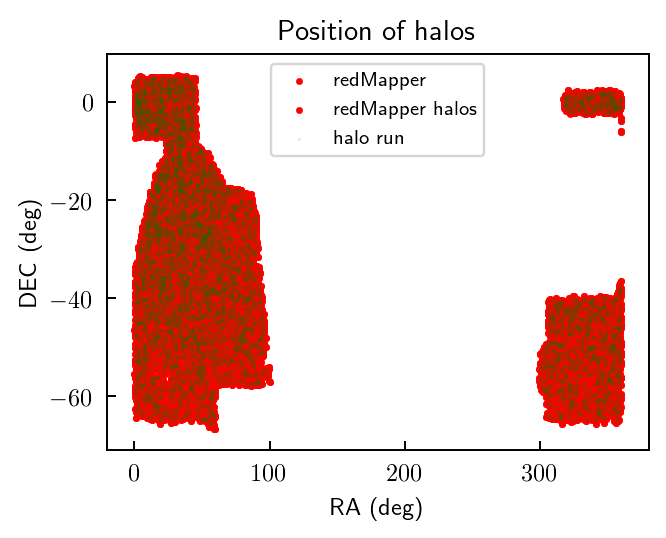

In [117]:
#Plotting in RA, DEC space
plt.figure(figsize=(4,3))
plt.scatter(matched_redM.RA, matched_redM.DEC, c='r', s=7, marker='o',linewidth=0.2, label='redMapper')
plt.scatter(redM_halos.RA_OBS, redM_halos.DEC_OBS, c='r', s=7, marker='o',linewidth=0.2, label='redMapper halos')
plt.scatter(hrun_data.RA, hrun_data.DEC, c='g', marker='.', s=5, linewidth=0.2, alpha=0.1, label='halo run')
#plt.scatter(halos_RA[::100], halos_DEC[::100], c='b', marker='.', s=5, linewidth=0.1, alpha=0.2, label='normal halos')
plt.xlabel('RA (deg)'); plt.ylabel('DEC (deg)')
plt.legend(fontsize=8, loc='upper center')
plt.title('Position of halos')
#plt.tight_layout()
#plt.savefig('halo_cluster_pos.png')
plt.show()

### Halo matching

#### Match redM_halos onto hrun_halos by ID

In [111]:
halos_matched_bool = np.isin(redM_halos.HALOID, hrun_data.HALOID)
halocut = np.where(halos_matched_bool == True)[0]
redM_halos = redM_halos[halocut]
print "After halocut number of halos in redM_halos is ", len(redM_halos)

After halocut number of halos in redM_halos is  16055


#### Match redM_halos onto hrun_halos by ID
CDKTree for sorting by ID. 
$$
from scipy.spatial import cKDTree
hid_truth_2d = np.dstack([hid_truth,hid_truth])[0]  # needs to be 2D arrays
mytree = cKDTree(hid_truth_2d)  
dist, indexes = mytree.query(np.dstack([hid_halorun,hid_halorun])[0])
$$

In [112]:
halos_matched_bool = np.isin(hrun_data.HALOID, redM_halos.HALOID)
halocut = np.where(halos_matched_bool == True)[0]
hrun_data = hrun_data[halocut]

#Halo_Run catalog has repeating halos. Clean that up
unique_ID, unique_ind = np.unique(hrun_data.HALOID, return_index=True)
hrun_data = hrun_data[unique_ind]

print "Before halocut but after mass cut number of halos in hrun is ", len(hrun_data)
print "After halocut number of halos in hrun is ", len(hrun_data)

Before halocut but after mass cut number of halos in hrun is  16055
After halocut number of halos in hrun is  16055


In [113]:
#Check that all IDs are one-to-one matched
ID_matched_bool = np.isin(redM_halos.HALOID, hrun_data.HALOID)
ID_matched_num = len(ID_matched_bool)
print "After halocut ", ID_matched_num, " out of ", len(redM_halos), "halos in redM_halos_halocut are in hrun_data_halocut"
ID_matched_bool = np.isin(hrun_data.HALOID, redM_halos.HALOID)
ID_matched_num = len(ID_matched_bool)
print "After halocut ", ID_matched_num, " out of ", len(hrun_data), "halos in hrun_data_halocut are in redM_halos_halocut"

After halocut  16055  out of  16055 halos in redM_halos_halocut are in hrun_data_halocut
After halocut  16055  out of  16055 halos in hrun_data_halocut are in redM_halos_halocut


#### Sorting by ID

#### Match sorted and cut redM_halos to matched_redM

In [115]:
redM_cut = [i for (i,x) in enumerate(matched_redM.matching_ID) if x in redM_halos.matching_ID]
#print redM_cut, len(redM_cut)
matched_redM = matched_redM[redM_cut]

#Sort by matching_ID
ID_sort = np.argsort(matched_redM.matching_ID)
matched_redM = matched_redM[ID_sort]
print "After sorting, IDs in matched_redM are: "
print matched_redM.matching_ID, "\n"

#For redM_halos
ID_sort = np.argsort(redM_halos.matching_ID)
redM_halos = redM_halos[ID_sort]
print "After sorting, IDs in redM_halos are: "
print redM_halos.matching_ID, "\n"


#For hrun
sort_idx = hrun_data.HALOID.argsort()
sort_idx = sort_idx[np.searchsorted(hrun_data.HALOID, redM_halos.HALOID, sorter = sort_idx)]
hrun_data = hrun_data[sort_idx]
print hrun_data.HALOID, len(sort_idx)
print redM_halos.HALOID

After sorting, IDs in matched_redM are: 
[    0     1     2 ... 18458 18459 18460] 

After sorting, IDs in redM_halos are: 
[    0     1     2 ... 18458 18459 18460] 

[110385189 124235235 117984266 ... 129086436 125178768 111291795] 16055
[110385189 124235235 117984266 ... 129086436 125178768 111291795]


### halo_run vs. matched_halos
For outliers in mass: check redshift, lambda, RA, DEC. Compare two catalogs. 

Plot ratio of lambda vs miscentering distance. Expect large miscentering for ratio away from 1.

#### Mass and Lambda comparison

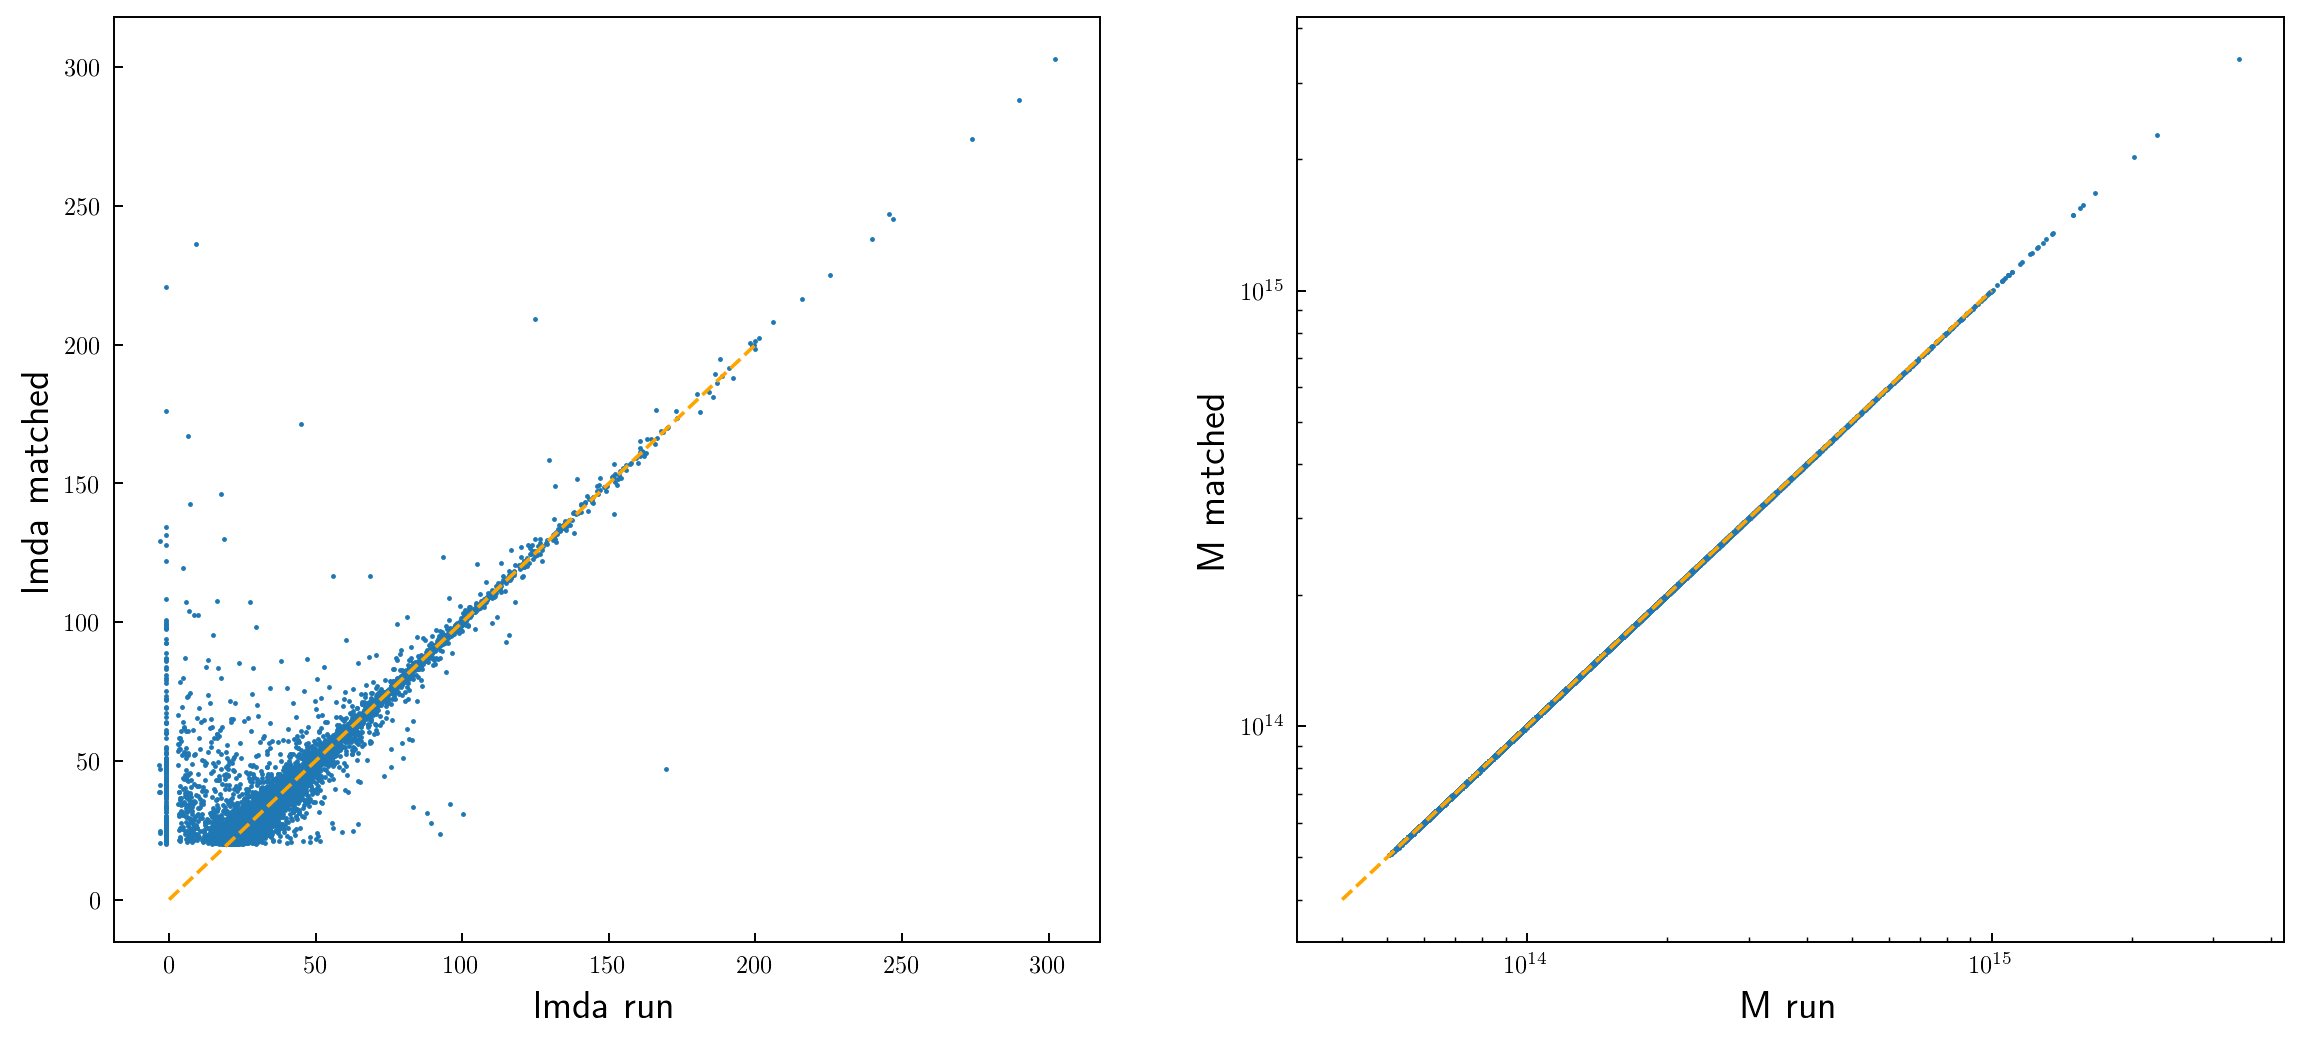

In [116]:
#np.random.shuffle(M_hrun)
#print M_hrun[0:10]
#print len(M_hrun), len(M_matched)

#Plotting
x_lmda = np.linspace(0,200,1000)
x_mass = np.linspace(4e13, 1e15, 1000)
fig, ax = plt.subplots(1,2, figsize = (16,7))
ax[0].scatter(hrun_data.LAMBDA_CHISQ, matched_redM.LAMBDA_CHISQ, s=1)
ax[0].plot(x_lmda, x_lmda, linestyle='--',color='orange')
ax[1].scatter(hrun_data.M200B, redM_halos.M200B, s=1)
ax[1].plot(x_mass, x_mass, linestyle='--', color='orange')

ax[0].set_xlabel('lmda run', fontsize=16)
ax[0].set_ylabel('lmda matched', fontsize=16)

ax[1].set_xlabel('M run', fontsize=16)
ax[1].set_ylabel('M matched', fontsize=16)
ax[1].set_yscale('log'); ax[1].set_xscale('log')

plt.show()

## Diagnosis for RA, DEC mismatch betweeen halorun and Buzzard

#### Separation in distance between halos in the catalogs. Should be 0, but isn't. Again, problem with halo mismatch. 

## Testing the rotation algorithm

* Import Buzzard halos before rotation
* Apply Chunhao's rotation for select halos
* Apply mine for select halos
* Use above code for 3D-separation to compare RA, DEC

#### Import Rotated RedMaPPer

#### Apply Chunhao's Rotation Algorithm

#### My rotation algo
PX, PY, PZ are normalized to sphere of radius 1

#### Compare separation between thet two

### Save halocut redM_halos onto a .dat file
Include the parameter hrun_lmda

In [ ]:
import numpy.lib.recfunctions as rfn
hrun_lambda = np.array(hrun_data_halocut.LAMBDA_CHISQ, dtype=[('hrun_lmda', 'f4')] )
print len(hrun_lmda)

assert len(hrun_lambda) == len(redM_halos_halocut), "Arrays have different number of halos"
arrays = [redM_halos_halocut, hrun_lambda]
redM_halos_halocut = rfn.merge_arrays(arrays, flatten = True, usemask = False) #Do it once only


In [ ]:
#np.save("redM_halos_hruncut_mcut5e13", redM_halos_halocut)

In [ ]:
print redM_halos_halocut.dtype
print redM_halos_halocut
redM_halos_halocut = redM_halos_halocut.view(np.recarray)

mass_sort = np.argsort(redM_halos_halocut.halos_M200b)
redM_msorted = redM_halos_halocut[mass_sort]
print "ID are ", redM_msorted['halos_ID'][:-10:-1], '\n'
print "Masses are", redM_msorted['halos_M200b'][:-10:-1], '\n'
print "Richnesss are", redM_msorted['redM_lmda'][:-10:-1], '\n'
print "RA are", redM_msorted['halos_RA'][:-10:-1], '\n'
print "DEC are", redM_msorted['halos_DEC'][:-10:-1], '\n'
